# Convolução

Neste exercício, iremos ver uma implementação simples da operação de convolução e aplicar um filtro a dígitos manuscritos do dataset MNIST. Este dataset será usado na próxima tarefa de classificação.

In [1]:
#@title Imports (RUN ME!) { display-mode: "form" }

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from tensorflow.keras import layers

plt.rcParams['figure.figsize'] = (15,15) # Configura tamanho das figuras

## Dado

O módulo **mnist** contém dados para treinamento e teste do modelo, com suas respectivas classes. Neste exercício, não usaremos os dados de teste. Ao invés disso, iremos separar 20% dos dados de trainamento para validação.

In [ ]:
mnist = tf.keras.datasets.mnist

# Carrega os dados, que já vem divididos em conjunto de treinamento e teste.
(x_trainVal, y_trainVal), (_, _) = mnist.load_data()

# Embaralha os dados e divide em 80% para treino, 20% para validação
nData = x_trainVal.shape[0]  
nTrain = int(nData * 0.8)  
randomIdx = np.random.permutation(np.arange(nData))
trainIdx = randomIdx[:nTrain] 
valIdx = randomIdx[nTrain:]

# Divide os dados
x_val, y_val = x_trainVal[valIdx], y_trainVal[valIdx]
x_train, y_train = x_trainVal[trainIdx], y_trainVal[trainIdx]

# Transforma as imagens de tipo inteiro para tipo float
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

print("Formato das imagens de treinamento", x_train.shape)
print("Formato dos rótulos de treinamento", y_train.shape)
print()

print("Formato das imagens de validação", x_val.shape)
print("Formato dos rótulos de validação", y_val.shape)

Vamos visualizar as nove primeiras imagens do conjunto de treinamento. O título de cada imagem mostra o rótulo ou classe  associada. 

In [ ]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Classe {}".format(y_train[i]))

## Parte 1: convolução

Abaixo, definimos uma função que convolve uma imagem com um filtro. Adicionamos uma borda de zeros na imagem para que a imagem de saída tenha mesma dimensão da de entrada (por que?). Estude esta função e procure entender todos os passos. 

In [ ]:
# Função que aplica convolução de um kernel (filtro) em uma imagem. 
# Obs: supõe que o kernel é quadrado (dimensões iguais)

def convolution(image, kernel):
    # Primeiramente, faremos padding na imagem inicial para que
    # a imagem filtrada fique com as mesmas dimensões da original.
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2
    
    # Cria uma imagem com zeros que receberá o resultado da convolução
    filtered_image = np.zeros_like(image)
    
    # Padding: usaremos a função pad() do pacote NumPy, que já implementa a aplicação de padding
    image = np.pad(image, pad_size, mode='constant')
    
    for i in range(image.shape[0]-kernel_size+1):
        for j in range(image.shape[1]-kernel_size+1):
            conv_sum = 0
            for k1 in range(kernel_size):
                for k2 in range(kernel_size):
                    conv_sum += image[i+k1,j+k2]*kernel[k1,k2]
            filtered_image[i,j] = conv_sum
                    
    return filtered_image

Abaixo, vamos convolver uma imagem sorteada do MNIST com um filtro de borramento:

$
\dfrac{1}{9}
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 
\end{bmatrix}
$

Cada pixel da imagem original será computado como uma média dos pixels vizinhos, o que causa o efeito de borramento. Experimente alterar o filtro, mantendo a soma dos elementos igual a 1. Ex: faça um filtro de borramento maior, de tamanho 5 $\times$ 5, dividindo por 25 ao invés de 9.

In [ ]:
# Define o filtro de borramento
sobel_x = np.array([[1,0,-1],
                   [2,0,-2],
                   [1,0,-1]])

sobel_y = np.array([[ 1, 2, 1],
                   [ 0, 0, 0],
                   [-1,-2,-1]])

gaussian_kernel = np.array([[1,1,1],
                            [1,1,1],
                            [1,1,1]]) * (1/9)
                            
# Sorteia uma imagem para filtrar
rand_ind = np.random.randint(0, 1000)
img = x_train[rand_ind] 
print("Imagem sorteada", rand_ind)

# Aplica convolução na imagem
filtered_img = convolution(img, gaussian_kernel)

# Mostra a imagem original e a imagem filtrada
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray', interpolation='none')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(filtered_img, cmap='gray', interpolation='none')
plt.title("Filtrada")
plt.show()

Na prática, essa implementação simples da operação de convolução é lenta demais para processar os 60 mil dados do MNIST. Usaremos então a função convolve() do pacote SciPy, que implementa a mesma operação porém de forma otimizada, para processar o dado inteiro. O dado de validação também deve ser processado, pois os dados de avaliação devem sofrer as mesmas transformações que os dados usados para treinar o modelo.

In [ ]:
from time import time
from scipy.ndimage import convolve

# Define o filtro de borramento
kernel = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]]) * (1/9)

x_train_blur = []
num_images = x_train.shape[0]
begin_clock = time()

print("Treinamento:")
for i in range(num_images):
    x_train_blur.append(convolve(x_train[i], kernel, mode='constant'))
print(num_images, "processadas em {:.1f}".format((time()-begin_clock)), "segundos.")
x_train_blur = np.array(x_train_blur)

x_val_blur = []
num_images = x_val.shape[0]
begin_clock = time()

print("Validação:")
for i in range(num_images):
    x_val_blur.append(convolve(x_val[i], kernel, mode='constant'))
print(num_images, "processadas em {:.1f}".format((time()-begin_clock)), "segundos.")
x_val_blur = np.array(x_val_blur)
print(x_train_blur.shape, x_val_blur.shape)

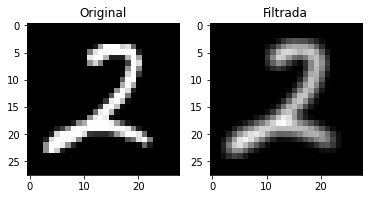

In [ ]:
# Sorteia uma imagem para visualizar
rand_ind = np.random.randint(0, 1000)
img = x_train[rand_ind] 
filtered_img = x_train_blur[rand_ind]

# Mostra a imagem original e a imagem filtrada
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray', interpolation='none')
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(filtered_img, cmap='gray', interpolation='none')
plt.title("Filtrada")
plt.show()

## Parte 2: classificação de dígitos com MLP

Nesta segunda parte, iremos usar uma _Multilayer Perceptron_ (MLP) de duas camadas para classificar os dígitos do MNIST. Faremos dois experimentos: treinamento com os dados originais e treinamento com os dados borrados.

Os rótulos de treinamento estão no formato 0, 1, 2, ..., 9. Para este problema multi-classes, o treinamento com o keras requer que estas classes sejam representadas como vetores _one-hot_, ou seja, vetores que possuem valor 1 na posição correspondente à classe do dado e 0 nas outras posições:

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]
...
9 -> [0, 0, 0, 0, 0, 0, 0, 0, 1]
```

Keras já tem um método para esta transformação, `tf.keras.utils.to_categorical`.

In [ ]:
# Temos 10 classes: os dígitos de 0 a 9
num_classes = len(np.unique(y_train))
print("número de classes:", num_classes)
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
print(y_train[0], y_train_oh[0])

número de classes: 10
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### Arquitetura

Construiremos uma função que cria uma MLP de duas camadas com as seguintes especificações:

- **Entrada**: cada imagem tem 28 $\times$ 28 pixels, porém a MLP espera como entrada um vetor unidimensional. Cada input será então retificado para um vetor de tamanho 28\*28=784, usando a camada 'flatten' do Keras;
- A primeira camada escondida terá 1024 neurônios e ativação ReLU;
- A segunda camada escondida terá 256 neurônios e ativação ReLU;
- **Saída**: este é um problema de 10 classes, portanto a saída da rede será um vetor de tamanho 10, com ativação Softmax.

In [ ]:
def create_model():
    # Definição do modelo
    model = tf.keras.Sequential()
    # Adiciona camada para retificar a entrada
    model.add(layers.Flatten())
    # Adiciona primeira camada escondida, com 1024 neurônios
    model.add(layers.Dense(1024, activation='relu'))
    # Adiciona segunda camada escondida, com 256 neurônios
    model.add(layers.Dense(256, activation='relu'))
    # Adiciona camada de saída com 10 neurônios e ativação Softmax
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

### Compilação e treinamento do modelo (dados originais)

Vamos definir o otimizador e a função de custo (_loss_) para treinar nosso MLP. A especificação da métrica 'accuracy' reporta a acurácia do modelo a cada época de treinamento. A função fit() treina o modelo.

In [ ]:
n_epochs = 50

model = create_model()
sgd = tf.keras.optimizers.SGD(lr=0.001) # lr = learning rate
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'], )
model.fit(x_train, y_train_oh, # Dados de treinamento e rótulos
          batch_size=128,   # Quantos dados serão usados por iteração
          epochs=n_epochs,  # Quantas épocas de treinamento
          verbose=1,        # Mostra o loss após cada época
          validation_data=(x_val, y_val_oh)) # Define conjunto de validação

In [ ]:
score = model.evaluate(x_val, y_val_oh, verbose=1)
print('Custo na validação: {:.2f}'.format(score[0]))
print('Acurácia na validação: {:.1f}%'.format(score[1]*100))

### Inspeção das saídas

É sempre instrutivo inspecionar exemplos de saídas corretas e incorretas. Vamos avaliar visualmente as predições do modelo.

In [ ]:
# A função predict_classes estima a classe de cada imagem em um conjunto
predicted_classes = np.argmax(model.predict(x_val), axis=-1)
print(predicted_classes)
# Checa quais predições foram corretas e incorretas
correct_indexes = np.nonzero(predicted_classes == y_val)[0]
print("Corretos:", correct_indexes.shape)
incorrect_indexes = np.nonzero(predicted_classes != y_val)[0]
print("Incorretos:", incorrect_indexes.shape)

In [ ]:
# Sorteia e plota exemplos corretos e incorretos
print("Predições corretas")
begin = np.random.randint(0, correct_indexes.size-9)
plt.figure()
for i, correct in enumerate(correct_indexes[begin:begin+3]):
    plt.subplot(1,3,i+1)
    plt.imshow(x_val[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_val[correct]))
plt.show()
print()
    
print("Predições erradas")
begin = np.random.randint(0, incorrect_indexes.size-9)
plt.figure()
for i, incorrect in enumerate(incorrect_indexes[begin:begin+3]):
    plt.subplot(1,3,i+1)
    plt.imshow(x_val[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_val[incorrect]))
plt.show()

### Compilação e treinamento do modelo (dados borrados)

Vamos repetir o mesmo experimento, porém agora com os dados borrados.

In [ ]:
n_epochs = 50

model = create_model()
sgd = tf.keras.optimizers.SGD(lr=0.001) # lr = learning rate
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'], )
model.fit(x_train_blur, y_train_oh, # Dados de treinamento e rótulos
          batch_size=128,   # Quantos dados serão usados por iteração
          epochs=n_epochs,  # Quantas épocas de treinamento
          verbose=1,        # Mostra o loss após cada época
          validation_data=(x_val_blur, y_val_oh)) # Define conjunto de validação

#Validação
score = model.evaluate(x_val_blur, y_val_oh, verbose=1)
print('Custo na validação: {:.2f}'.format(score[0]))
print('Acurácia na validação: {:.1f}%'.format(score[1]*100))

### Inspeção das saídas

In [ ]:
# A função predict_classes estima a classe de cada imagem em um conjunto
predicted_classes = np.argmax(model.predict(x_val_blur), axis=-1)
print(predicted_classes)
# Checa quais predições foram corretas e incorretas
correct_indexes = np.nonzero(predicted_classes == y_val)[0]
print("Corretos:", correct_indexes.shape)
incorrect_indexes = np.nonzero(predicted_classes != y_val)[0]
print("Incorretos:", incorrect_indexes.shape)

# Sorteia e plota exemplos corretos e incorretos
print("Predições corretas")
begin = np.random.randint(0, correct_indexes.size-9)
plt.figure()
for i, correct in enumerate(correct_indexes[begin:begin+3]):
    plt.subplot(1,3,i+1)
    plt.imshow(x_val_blur[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_val[correct]))
plt.show()
print()
    
print("Predições erradas")
begin = np.random.randint(0, incorrect_indexes.size-9)
plt.figure()
for i, incorrect in enumerate(incorrect_indexes[begin:begin+3]):
    plt.subplot(1,3,i+1)
    plt.imshow(x_val_blur[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_val[incorrect]))
plt.show()

## Conclusão

O borramento dos dados teve algum impacto na acurácia do modelo? Discuta os resultados.